In [2]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import optuna

import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator

from keras import Input, Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    batch_size = 32
    img_height = 180
    img_width = 180
    hyper_tune = False

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(2023)

In [5]:
train_normal_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/train/NORMAL'
train_pneu_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/train/PNEUMONIA'
train_normal_list_path = os.listdir(train_normal_path)
train_pneu_list_path = os.listdir(train_pneu_path)

valid_normal_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/NORMAL'
valid_pneu_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA'
valid_normal_list_path = os.listdir(valid_normal_path)
valid_pneu_list_path = os.listdir(valid_pneu_path)

test_normal_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/test/NORMAL'
test_pneu_path = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/test/PNEUMONIA'
test_normal_list_path = os.listdir(test_normal_path)
test_pneu_list_path = os.listdir(test_pneu_path)

In [6]:
# Create Data
len_train_normal = len(train_normal_list_path)
len_train_pneu = len(train_pneu_list_path)
len_valid_normal = len(valid_normal_list_path)
len_valid_pneu = len(valid_pneu_list_path)
len_test_normal = len(test_normal_list_path)
len_test_pneu = len(test_pneu_list_path)

len_normal = [len_train_normal, len_valid_normal, len_test_normal]
len_pneu = [len_train_pneu, len_valid_pneu, len_test_pneu]

# Create Subplots
data_split = ["Training", "Validation", "Testing"]
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=data_split
)

for i in range(3):
    total = len_normal[i] + len_pneu[i]
    
    # Bar Chart
    fig.add_trace(
        go.Bar(
            x=["Normal", "Pneumonia"],
            y=[len_normal[i], len_pneu[i]],
            name=data_split[i],
            width=0.65,
            marker_color=["#1a7e96", "#ff4752"],
            text=[f"<b>{(value/total*100):.1f}%</b>" for value in [len_normal[i], len_pneu[i]]],
            textfont_size=13,
            textfont_color="white"
        ), row=1, col=i+1
    )

    # Update Axes
    fig.update_xaxes(ticks="outside", linecolor="Black", row=1, col=i+1)
    fig.update_yaxes(ticks="outside", linecolor="Black", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Class Distribution", title_x=0.5, font_size=14,
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False
)

# Show
fig.show(renderer="iframe_connected")

In [7]:
def plot_chest_xray_image(path, list_path, title):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        image = load_img(path + "/" + list_path[i])
        plt.imshow(image)
        plt.axis("off")
        plt.title(list_path[i], fontsize=10)
    plt.suptitle(title + " Class")

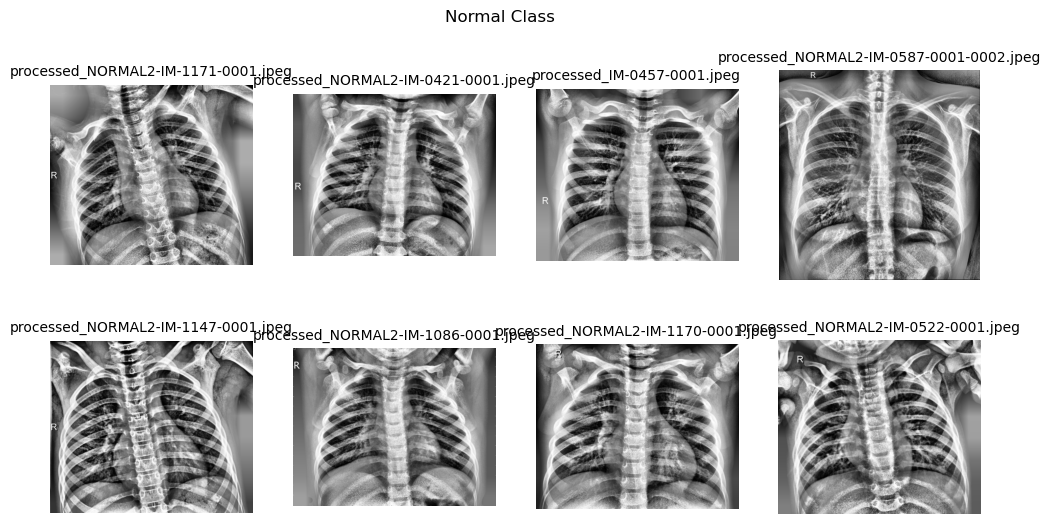

In [8]:
plot_chest_xray_image(train_normal_path, train_normal_list_path, title="Normal")


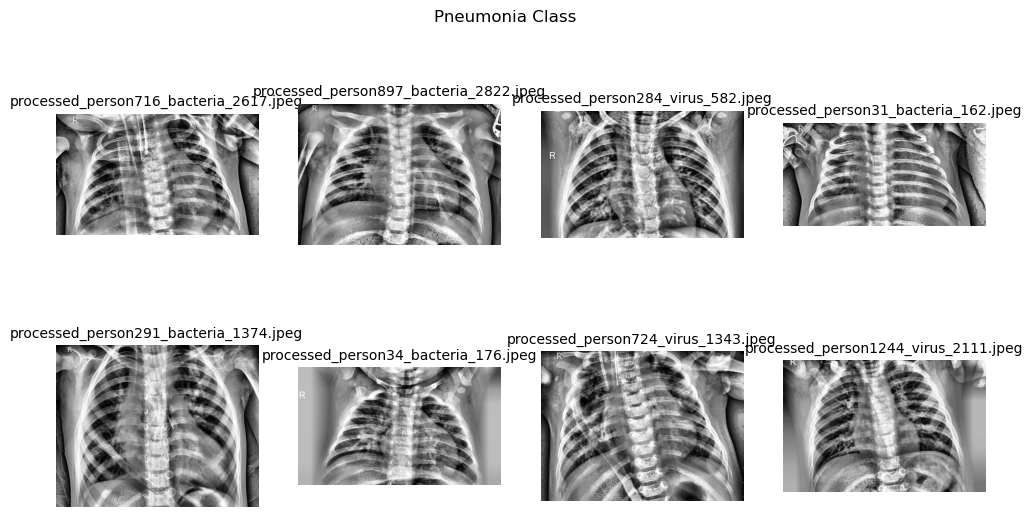

In [9]:
plot_chest_xray_image(train_pneu_path, train_pneu_list_path, title="Pneumonia")

In [10]:
# Data Augmentation
def data_augmentation():
    # Training Dataset
    TRAINING_DIR = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/train'
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.15
    )
    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode="binary",
        shuffle=True,
        subset="training"
    )

    # Validation Dataset
    validation_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode='binary',
        shuffle=False,
        subset="validation"
    )

    # Testing Dataset
    TESTING_DIR = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/test'
    test_datagen = ImageDataGenerator(rescale=1./255.)
    test_generator = test_datagen.flow_from_directory(
        TESTING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=1,
        class_mode='binary',
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = data_augmentation()

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# Create the Model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(CFG.img_height, CFG.img_width, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(
    optimizer=RMSprop(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['acc', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')
            ]
)

# Model Summary
display(model.summary())

# Create Callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=3
)

model_checkpoint = ModelCheckpoint(
    "CNN_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Train Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator)//4,
    callbacks=callbacks,
)

# Evaluate on Testing data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[1], scores[1]*100))
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[2], scores[2]*100))
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[3], scores[3]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

None

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.6174 - acc: 0.7244 - precision: 0.7495 - recall: 0.9463
Epoch 1: val_loss improved from inf to 0.57650, saving model to CNN_model.h5
34/34 [==============================] - 75s 2s/step - loss: 0.6174 - acc: 0.7244 - precision: 0.7495 - recall: 0.9463 - val_loss: 0.5765 - val_acc: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.5567 - acc: 0.7616 - precision: 0.7616 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.57650
34/34 [==============================] - 84s 2s/step - loss: 0.5567 - acc: 0.7616 - precision: 0.7616 - recall: 1.0000 - val_loss: 0.7701 - val_acc: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5735 - acc: 0.7482 - precision: 0.7482 - recall: 1.0000
Epoch 3: val_loss improved from 0.57650 to 0.56924, saving model to CNN_model.h5
34/34 [========

In [14]:
# Visualize Training Results

hp_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Create Subplot
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy", "Model Precision", "Model Recall"], 
)

# Loss Plot
loss = hp_history.history['loss']
val_loss = hp_history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = hp_history.history['acc']
val_acc = hp_history.history['val_acc']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Precision Plot
precision = hp_history.history['precision']
val_precision = hp_history.history['val_precision']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(precision)+1), y=precision,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Precision"
    ), row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_precision)+1), y=val_precision,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Precision"
    ), row=2, col=1
)

# Recall Plot
recall = hp_history.history['recall']
val_recall = hp_history.history['val_recall']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(recall)+1), y=recall,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Recall"
    ), row=2, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_recall)+1), y=val_recall,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Recall"
    ), row=2, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=2, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=2, col=2)
fig.update_yaxes(title="BCE Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Precision", linecolor="Black", ticks="outside", row=2, col=1)
fig.update_yaxes(title="Recall", linecolor="Black", ticks="outside", row=2, col=2)

# Update Layout
fig.update_layout(
    title="CNN Training and Validation Results after Hyperparameter tuning", title_x=0.5,
    width=950, height=800,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

NameError: name 'x_train' is not defined